In [1]:
!pip list

Package                  Version
------------------------ -----------
anyio                    3.6.2
argon2-cffi              21.3.0
argon2-cffi-bindings     21.2.0
arrow                    1.2.3
asttokens                2.0.5
astunparse               1.6.3
attrs                    22.1.0
backcall                 0.2.0
beautifulsoup4           4.11.1
bleach                   5.0.1
brotlipy                 0.7.0
certifi                  2022.9.24
cffi                     1.15.0
chardet                  4.0.0
charset-normalizer       2.0.4
colorama                 0.4.4
comm                     0.1.2
conda                    22.9.0
conda-build              3.22.0
conda-content-trust      0+unknown
conda-package-handling   1.8.1
contourpy                1.0.6
cryptography             36.0.0
cycler                   0.11.0
debugpy                  1.6.4
decorator                5.1.1
defusedxml               0.7.1
entrypoints              0.4
exceptiongroup           1.0.0
executing       

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
%matplotlib inline

In [2]:
root = './data'

In [3]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=(0.5,), std=(0.5,))])
train_dataset = datasets.FashionMNIST(root, transform=transform, train=True, download=True)
test_dataset = datasets.FashionMNIST(root, transform=transform, train=False, download=True)

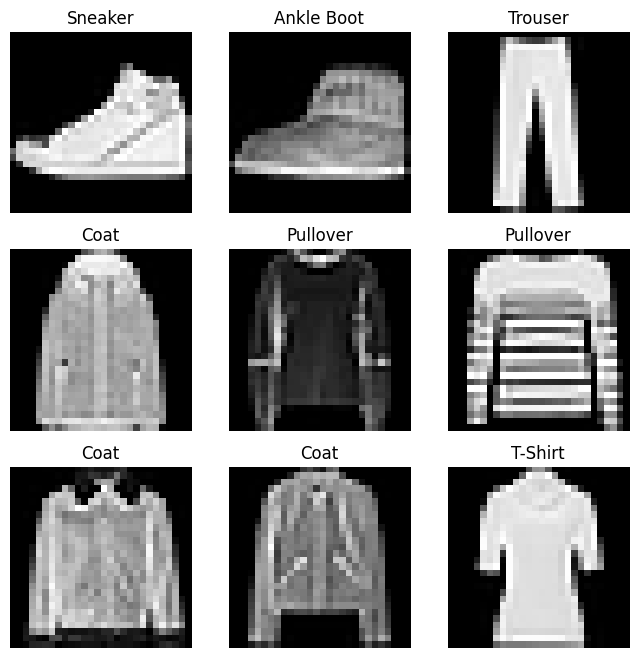

In [35]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

cols, rows = 3, 3
sample_idxs = torch.randint(len(train_dataset), (rows * cols,))

figure = plt.figure(figsize=(8, 8))
for i, sample_idx in enumerate(sample_idxs, start=1):
    img, label = train_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

# 완전연결신경망 네트워크 설계

fashionMNIST 문제를 풀기 위한 완전연결신경망 네트워크를 설계한다.  
여기서는 입력층 1개, 은닉층 1개, 출력층 1개로 이루어진 2층 신경망을 설계한다.  
이 때, 출력층에서 활성화 함수는 softmax 함수를, 손실 함수는 CCE(categorical-cross entropy-error)를 사용한다.

In [52]:
# 계산 그래프를 정의하기 위한 계층 모듈 클래스들을 정의한다
class Affine:
    def __init__(self, w, b):
        self.x = None
        self.W = w
        self.b = b
        self.dW = None
        self.db = None
    
    def forward(self, x):
        self.x = x
        out = np.dot(x, self.W)
        out += self.b # broadcasting
        
        return out
    
    def backward(self, dout):
        dX = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis=0)
        
        return dX
    

class Relu:
    def __init__(self):
        self.mask = None
    
    def forward(self, x):
        self.mask = (x <= 0)
        out = x.copy() # 메서드에 인자로 시퀀스형 자료를 전달하는 경우 얕은 복사, 깊은 복사를 주의하자
        out[self.mask] = 0
        
        return out
    
    def backward(self, dout):
        dout[self.mask] = 0
        
        return dout

class SoftmaxWithCrossEntropy:
    def __init__(self):
        self.y = None
    
    def softmax(self, x):
        max_val = x.max()
        x -= max_val # broadcasting
        exp_x = np.exp(x)
        sum_exp_x = np.sum(exp_x, axis=1)
        
        return exp_x / sum_exp_x.reshape(-1, 1)
    
    def cross_entropy(self, y, t):
        delta = 1e-7
        if y.ndim == 1:
            y = y.reshape(1, y.size)
            t = t.reshape(1, t.size)
        
        return -np.sum(t * np.log(y + delta)) / y.shape[0]
    
    def forward(self, x, t):
        self.y = self.softmax(x)
        loss = self.cross_entropy(self.y, t)
        
        return loss
    
    def backward(self, t):
        
        return (self.y - t) / self.y.shape[0]


In [69]:
from collections import OrderedDict


# 신경망 정의
class FNN:
    def __init__(self, input_size, hidden_size, output_size):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.params = {}
        self.params['W1'] = np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)
        
        self.layers = OrderedDict()
        self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1'])
        self.layers['Relu1'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2'])
        
        self.last_layer = SoftmaxWithCrossEntropy() # 실제 추론시에는 손실함수를 계산할 필요가 없다
        
        self.loss = None
    
    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
        
        return x
        
    def train(self, x, t):
        y = self.predict(x)
        t_enc = np.eye(self.output_size)[t] # one-hot-encoding
        self.loss = self.last_layer.forward(y, t_enc)
        
        dout = self.last_layer.backward(t_enc)
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)
        
        grads = {}
        grads['W1'] = self.layers['Affine1'].dW
        grads['b1'] = self.layers['Affine1'].db
        grads['W2'] = self.layers['Affine2'].dW
        grads['b2'] = self.layers['Affine2'].db
        
        return grads
    
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        accuracy = np.sum(y == t) / x.shape[0]
        
        return accuracy
               

In [28]:
X_train = np.array([train_data[0].numpy().reshape(-1) for train_data in train_dataset])
y_train = np.array([train_data[1] for train_data in train_dataset])

In [23]:
print(f"X_train.shape: {X_train.shape}")
print(f"y_train.shape: {y_train.shape}")

X_train.shape: (60000, 784)
y_train.shape: (60000,)


In [29]:
X_test = np.array([train_data[0].numpy().reshape(-1) for train_data in test_dataset])
y_test = np.array([train_data[1] for train_data in test_dataset])

In [30]:
print(f"X_test.shape: {X_test.shape}")
print(f"y_test.shape: {y_test.shape}")

X_test.shape: (10000, 784)
y_test.shape: (10000,)


In [70]:
input_size = 784
hidden_size = 50
output_size = 10
iter_num = 10000
batch_size = 64
iter_per_epoch = np.ceil(X_train.shape[0] / batch_size)
learning_rate = 0.01
train_loss_list = []
train_acc_list = []
test_acc_list = []

fnn = FNN(input_size, hidden_size, output_size)
for i in range(iter_num):
    batch_mask = np.random.choice(X_train.shape[0], batch_size)
    X_batch = X_train[batch_mask]
    y_batch = y_train[batch_mask]
    
    grad = fnn.train(X_batch, y_batch)
    
    for key in ('W1', 'b1', 'W2', 'b2'):
        fnn.params[key] -= learning_rate * grad[key]
    
    train_loss_list.append(fnn.loss)
    
    if i % iter_per_epoch == 0:
        train_acc = fnn.accuracy(X_train, y_train)
        test_acc = fnn.accuracy(X_test, y_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)


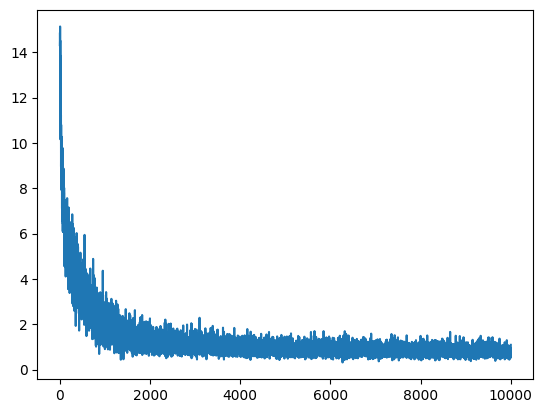

In [71]:
plt.plot(train_loss_list)

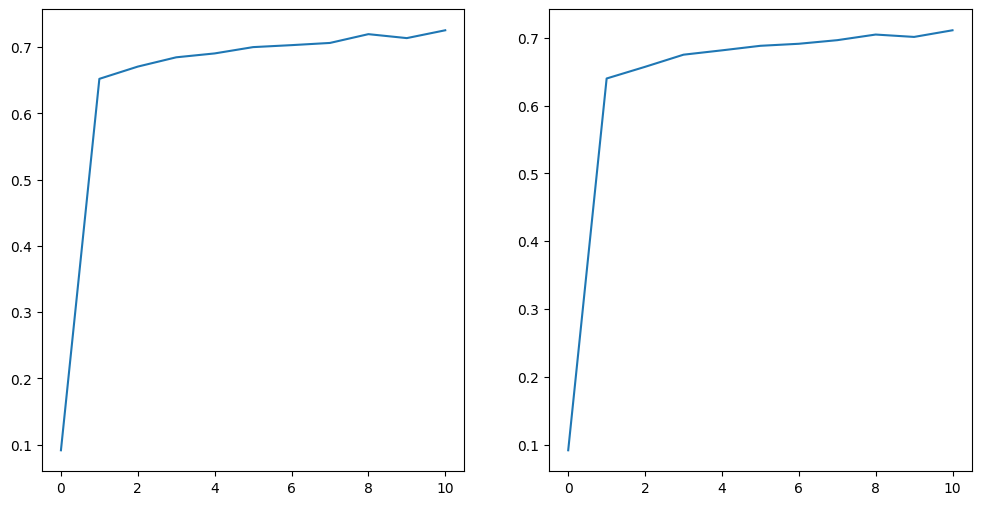

In [81]:
figure = plt.figure(figsize=(12, 6))
figure.add_subplot(1, 2, 1)
plt.plot(train_acc_list)
figure.add_subplot(1, 2, 2)
plt.plot(test_acc_list)
plt.show()

In [77]:
np.argmax(fnn.predict(X_test[0]))

9

In [78]:
y_test[0]

9

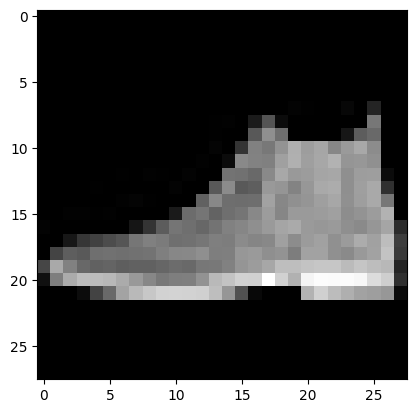

In [80]:
plt.imshow(test_dataset[0][0].squeeze(), cmap="gray")

# 파이토치를 이용한 완전연결신경말 설계

In [69]:
# 하이퍼파라미터
input_size = 784
hidden_size = 50
output_size = 10
batch_size = 64
learning_rate = 0.01
iter_num = 10000
iter_per_epoch = np.ceil(len(train_dataset) / batch_size)
epochs = iter_num // iter_per_epoch

In [70]:
from torch.utils.data import DataLoader


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [71]:
X_train = np.array([train_data[0].numpy().reshape(-1) for train_data in train_dataset])
y_train = np.array([train_data[1] for train_data in train_dataset])

In [72]:
X_test = np.array([train_data[0].numpy().reshape(-1) for train_data in test_dataset])
y_test = np.array([train_data[1] for train_data in test_dataset])

In [160]:
class FNN(torch.nn.Module):
    def __init__(self):
        super(FNN, self).__init__()
        self.layer = torch.nn.Sequential(
            torch.nn.Linear(input_size, hidden_size),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_size, output_size)
        )
        
    def forward(self, x):
        x = x.view(x.size(0), -1) # flatten
        x_out = self.layer(x)
        
        return x_out
    
    def accuracy(self, x, t):
        y = self.layer(x).detach().numpy()
        y = np.argmax(y, axis=1)
        accuracy = np.sum(y == t) / x.shape[0]
        
        return accuracy

In [161]:
def weights_init(m):
    if isinstance(m, torch.nn.Linear):
        torch.nn.init.normal_(m.weight)
        torch.nn.init.zeros_(m.bias)
        
device = "cuda" if torch.cuda.is_available() else "cpu" 
model = FNN().to(device)
model.apply(weights_init) # 가중치 초기화

FNN(
  (layer): Sequential(
    (0): Linear(in_features=784, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=10, bias=True)
  )
)

In [162]:
criterion = torch.nn.CrossEntropyLoss() # 손실함수 정의
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate) # 최적화 알고리즘 정의

In [163]:
model.train()
train_loss_list = []
train_acc_list = []
test_acc_list = []
for epoch in range(int(epochs)):
    for i, (imgs, labels) in enumerate(train_loader):
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        optimizer.zero_grad() # 중요
        loss.backward()
        optimizer.step()
        
        train_loss_list.append(loss.item())
        
        if i % iter_per_epoch == 0:
            model.eval()
            train_acc_list.append(model.accuracy(torch.Tensor(X_train), y_train))
            test_acc_list.append(model.accuracy(torch.Tensor(X_test), y_test))
            model.train()

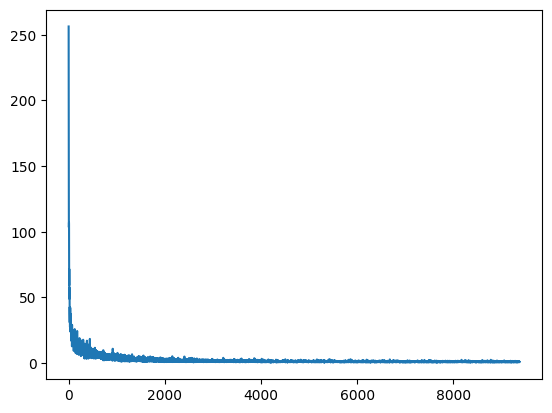

In [164]:
plt.plot(train_loss_list)

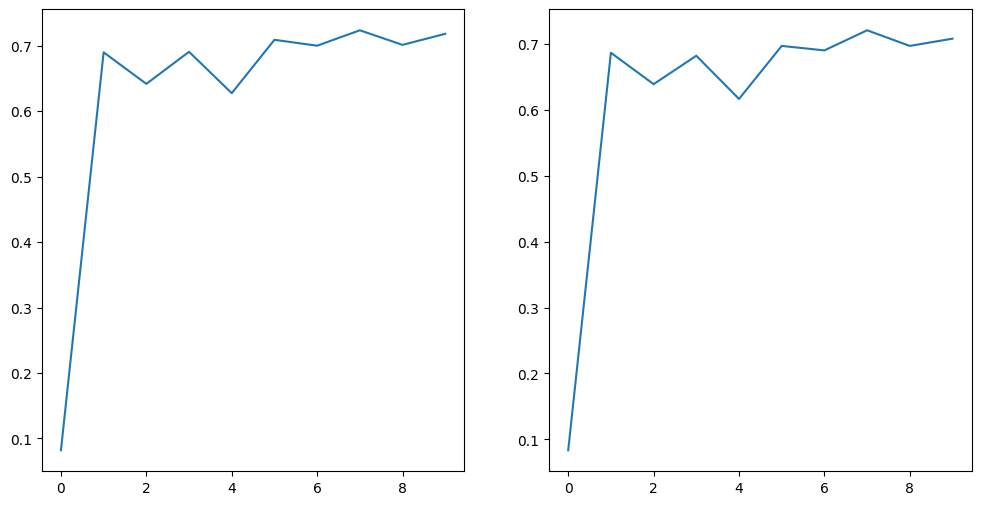

In [165]:
figure = plt.figure(figsize=(12, 6))
figure.add_subplot(1, 2, 1)
plt.plot(train_acc_list)
figure.add_subplot(1, 2, 2)
plt.plot(test_acc_list)
plt.show()

In [168]:
model.eval()
np.argmax(model(test_dataset[9][0].unsqueeze(dim=0).to(device)).detach().numpy())

7

In [169]:
test_dataset[9][1]

7

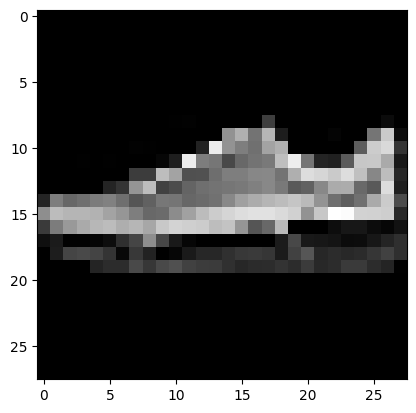

In [172]:
plt.imshow(test_dataset[9][0].squeeze(), cmap="gray")

# 성능 높이기

In [1]:
import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
root = './data'
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=(0.5,), std=(0.5,))])
train_dataset = datasets.FashionMNIST(root=root, train=True, transform=transform)
test_dataset = datasets.FashionMNIST(root=root, train=False, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [26]:
class FNN(nn.Module):
    def __init__(self):
        super(FNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784, 50),
            nn.BatchNorm1d(50),
            nn.ReLU()
        )
        self.layer2 = nn.Sequential(
            nn.Linear(50, 10)
        )
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        
        return out

In [27]:
def weights_init(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)

In [28]:
device = "gpu" if torch.cuda.is_available() else "cpu"
model = FNN().to(device)
model.apply(weights_init)

FNN(
  (layer1): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=50, bias=True)
    (2): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
  )
  (layer2): Sequential(
    (0): Linear(in_features=50, out_features=10, bias=True)
  )
)

In [29]:
model.eval()
with torch.no_grad():
    total = 0
    correct = 0
    for i, (imgs, labels) in enumerate(test_loader):
        preds = model(imgs)
        preds = torch.argmax(preds, dim=1)
        correct += (preds == labels).sum().item()
        total += imgs.size(0)

print(f"Test accuracy: {correct / total * 100: .2f}%")

Test accuracy:  8.07%


In [30]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.01)

In [31]:
model.train()
train_loss_list = []
for _ in range(10):
    for i, (imgs, labels) in enumerate(train_loader):
        imgs, labels = imgs.to(device), labels.to(device)
        preds = model(imgs)
        loss = criterion(preds, labels)
        train_loss_list.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

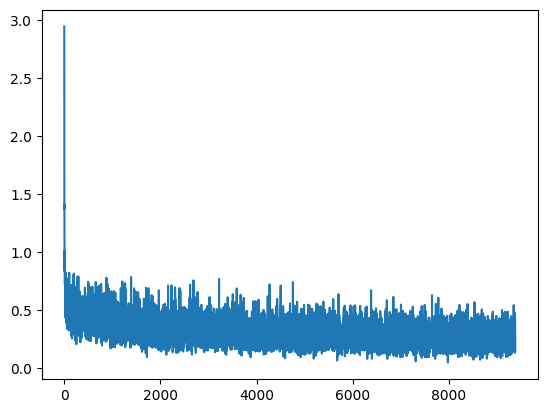

In [32]:
plt.plot(train_loss_list)

In [33]:
model.eval()
with torch.no_grad():
    total = 0
    correct = 0
    for i, (imgs, labels) in enumerate(test_loader):
        preds = model(imgs)
        preds = torch.argmax(preds, dim=1)
        correct += (preds == labels).sum().item()
        total += imgs.size(0)

print(f"Test accuracy: {correct / total * 100: .2f}%")

Test accuracy:  87.75%


In [36]:
model.eval()
with torch.no_grad():
    pred = model(test_dataset[2][0])
    pred = torch.argmax(pred, dim=1).item()
    print(pred)

1


In [37]:
test_dataset[2][1]

1

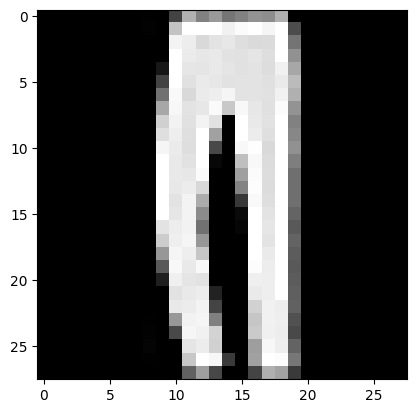

In [42]:
plt.imshow(test_dataset[2][0].squeeze(), cmap="gray")